## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("./scaled_dataset.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max,building_id
0,0.8,143.0,210,1.72,218.0,94.6,0.434,6.255319,7,61.340426,...,1031.902128,1030.8,1034.5,256.340426,227,312,5.036170,2.2,7.4,1
1,16.9,143.0,210,1.72,218.0,94.6,0.434,3.375000,5,59.520833,...,1034.843750,1031.6,1038.1,317.437500,294,339,6.245833,2.0,7.6,1
2,1.4,143.0,210,1.72,218.0,94.6,0.434,-0.666667,2,59.916667,...,1038.256250,1037.5,1039.3,290.979167,211,345,2.154167,1.1,3.5,1
3,6.6,143.0,210,1.72,218.0,94.6,0.434,1.083333,3,63.166667,...,1037.075000,1035.6,1038.6,227.041667,2,359,2.637500,0.6,4.6,1
4,0.3,143.0,210,1.72,218.0,94.6,0.434,2.479167,4,60.812500,...,1032.722917,1031.7,1035.6,259.770833,236,287,5.212500,3.7,6.2,1


## Preoaring the (x,y) pairs

### Scaling the data

In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [3]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [4]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [5]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((10847, 24, 35), (10847,))

### Splitting the data

In [6]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((8696, 24, 35), (8696,), (1087, 24, 35), (1087,), (1064, 24, 35), (1064,))

### Plotting the splits

In [7]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

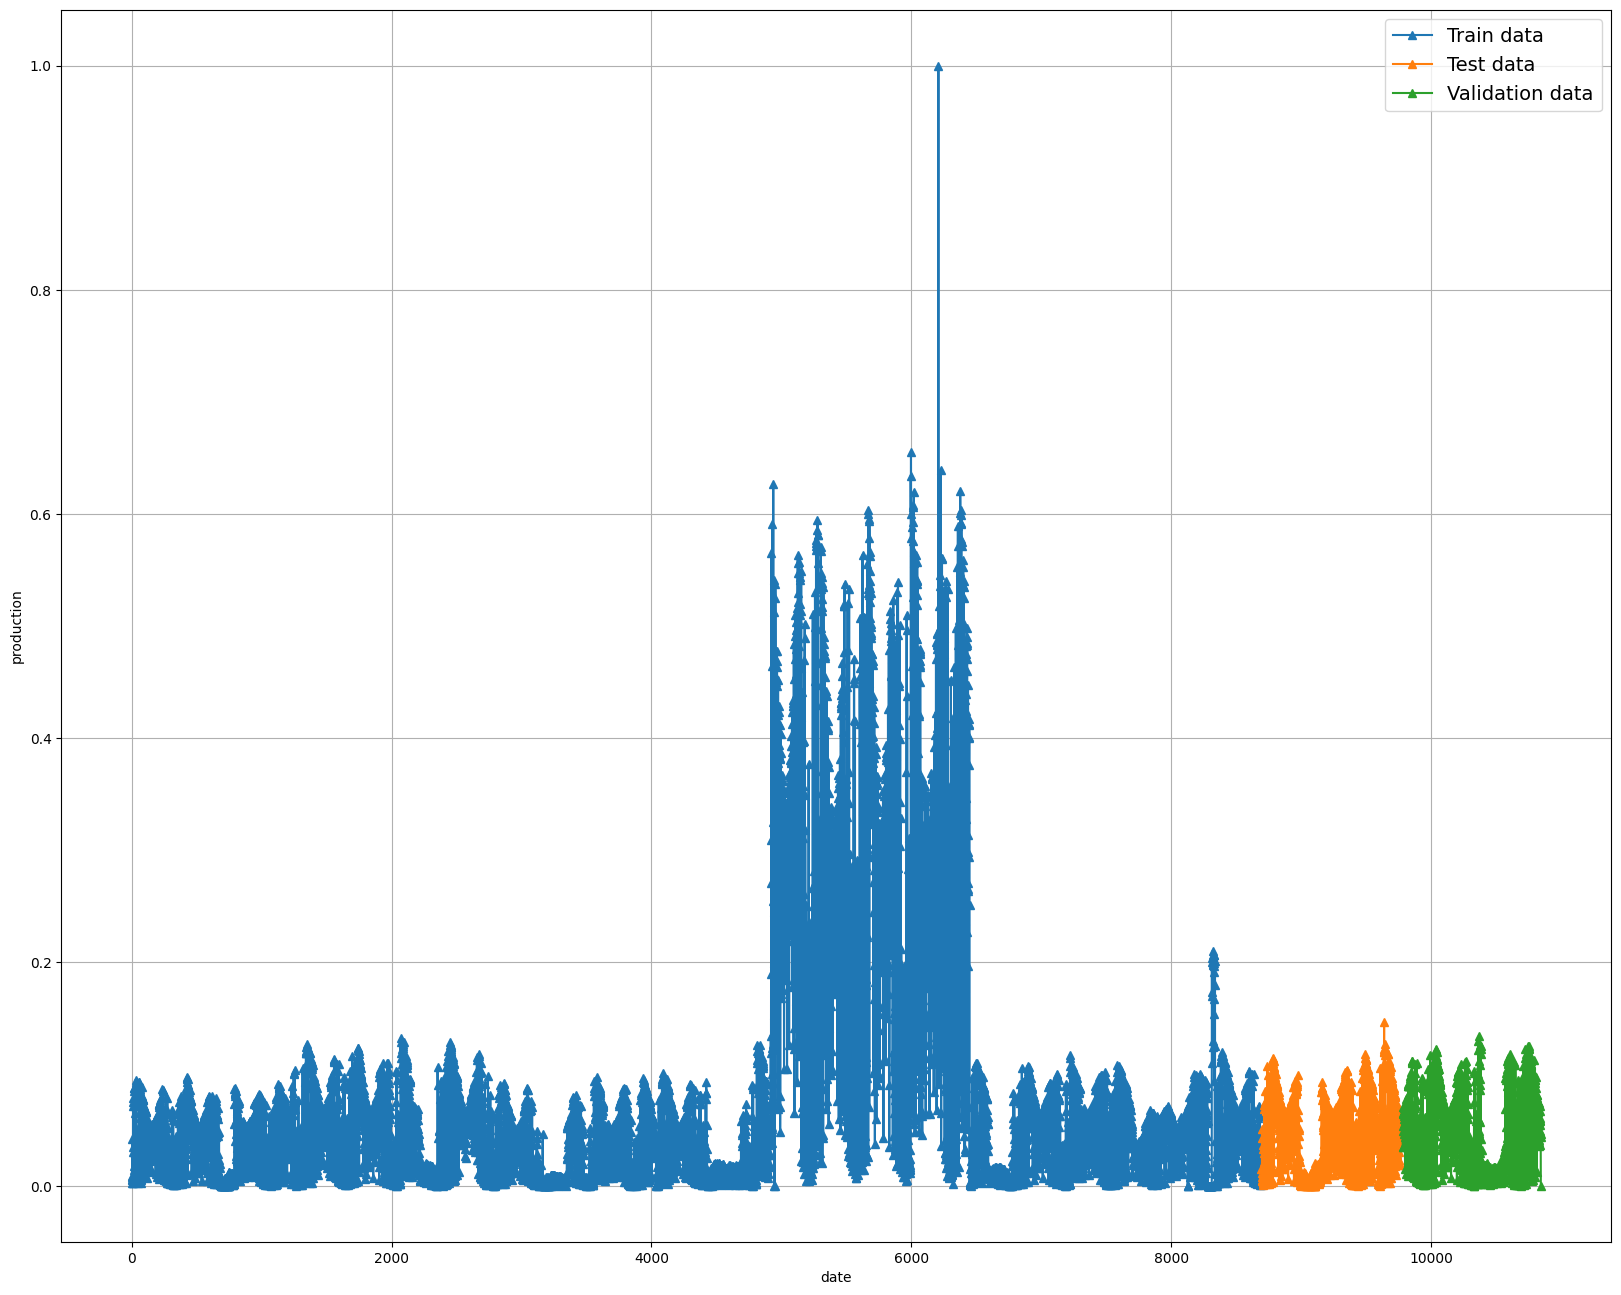

In [8]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [10]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [11]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [12]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [13]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [15]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [16]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(8696, 24, 35) -> (8696, 24, 1, 35)


In [17]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=64, kernel_size=(1,), activation='tanh',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=64, kernel_size=(1,),
               activation='tanh', return_sequences=False),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

conv_lstm_model.summary()


Model: "model_conv_lstm.keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 24, 1, 64)         25600     
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 1, 64)             33024     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 62849 (245.50 KB)
Trainable params: 62849 (245.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Training the model convlstm

In [18]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 09:42:34] [setup] RAM Tracking...
[codecarbon INFO @ 09:42:34] [setup] CPU Tracking...
[codecarbon WARNING @ 09:42:34] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 09:42:36] We saw that you have a 12th Gen Intel(R) Core(TM) i7-12700H but we don't know it. Please contact us.
[codecarbon INFO @ 09:42:36] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i7-12700H
[codecarbon INFO @ 09:42:36] [setup] GPU Tracking...
[codecarbon INFO @ 09:42:37] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:42:37] >>> Tracker's metadata:
[codecarbon INFO @ 09:42:37]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 09:42:37]   Python version: 3.11.3
[codecarbon INFO @ 09:42:37]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 09:42:37]   Available RAM : 31.711 GB
[codecarbon INFO @ 09:42:37]   CPU count: 20
[codecarbon INFO @ 09:42:37]   CPU

In [19]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [20]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300



[codecarbon INFO @ 09:42:48] Energy consumed for RAM : 0.000033 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:42:48] Energy consumed for all CPUs : 0.000118 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:42:49] Energy consumed for all GPUs : 0.000003 kWh. Total GPU Power : 1.0903489793395313 W
[codecarbon INFO @ 09:42:49] 0.000155 kWh of electricity used since the beginning.


17/17 [==============================] - 17s 293ms/step - loss: 0.0704 - val_loss: 0.0361
Epoch 2/300
17/17 [==============================] - 3s 161ms/step - loss: 0.0439 - val_loss: 0.0293
Epoch 3/300
 2/17 [==>...........................] - ETA: 2s - loss: 0.0422

[codecarbon INFO @ 09:42:58] Energy consumed for RAM : 0.000061 kWh. RAM Power : 11.891499996185303 W


 3/17 [====>.........................] - ETA: 2s - loss: 0.0435

[codecarbon INFO @ 09:42:58] Energy consumed for all CPUs : 0.000220 kWh. Total CPU Power : 42.5 W


13/17 [=====================>........] - ETA: 0s - loss: 0.0411

[codecarbon INFO @ 09:42:59] Energy consumed for all GPUs : 0.000012 kWh. Total GPU Power : 3.885486549013659 W
[codecarbon INFO @ 09:42:59] 0.000294 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 155ms/step - loss: 0.0407 - val_loss: 0.0286
Epoch 4/300
17/17 [==============================] - 3s 161ms/step - loss: 0.0400 - val_loss: 0.0283
Epoch 5/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0389 - val_loss: 0.0277
Epoch 6/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0384

[codecarbon INFO @ 09:43:08] Energy consumed for RAM : 0.000090 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:43:08] Energy consumed for all CPUs : 0.000322 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 171ms/step - loss: 0.0382 - val_loss: 0.0275
Epoch 7/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0362

[codecarbon INFO @ 09:43:09] Energy consumed for all GPUs : 0.000022 kWh. Total GPU Power : 4.1271864918099235 W
[codecarbon INFO @ 09:43:09] 0.000434 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 170ms/step - loss: 0.0377 - val_loss: 0.0272
Epoch 8/300
17/17 [==============================] - 3s 177ms/step - loss: 0.0376 - val_loss: 0.0268
Epoch 9/300
17/17 [==============================] - 3s 156ms/step - loss: 0.0379 - val_loss: 0.0262
Epoch 10/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0379

[codecarbon INFO @ 09:43:18] Energy consumed for RAM : 0.000118 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:43:18] Energy consumed for all CPUs : 0.000424 kWh. Total CPU Power : 42.5 W


16/17 [===========================>..] - ETA: 0s - loss: 0.0372

[codecarbon INFO @ 09:43:19] Energy consumed for all GPUs : 0.000032 kWh. Total GPU Power : 4.174287986732702 W
[codecarbon INFO @ 09:43:19] 0.000575 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 153ms/step - loss: 0.0374 - val_loss: 0.0261
Epoch 11/300
17/17 [==============================] - 3s 155ms/step - loss: 0.0366 - val_loss: 0.0259
Epoch 12/300
17/17 [==============================] - 3s 149ms/step - loss: 0.0361 - val_loss: 0.0251
Epoch 13/300
17/17 [==============================] - 3s 152ms/step - loss: 0.0361 - val_loss: 0.0262
Epoch 14/300
 3/17 [====>.........................] - ETA: 1s - loss: 0.0377

[codecarbon INFO @ 09:43:28] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:43:28] Energy consumed for all CPUs : 0.000526 kWh. Total CPU Power : 42.5 W


13/17 [=====================>........] - ETA: 0s - loss: 0.0361

[codecarbon INFO @ 09:43:29] Energy consumed for all GPUs : 0.000042 kWh. Total GPU Power : 4.057288977075149 W
[codecarbon INFO @ 09:43:29] 0.000715 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 150ms/step - loss: 0.0361 - val_loss: 0.0254
Epoch 15/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0354 - val_loss: 0.0266
Epoch 16/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0350 - val_loss: 0.0282
Epoch 17/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0356

[codecarbon INFO @ 09:43:38] Energy consumed for RAM : 0.000175 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:43:38] Energy consumed for all CPUs : 0.000627 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 164ms/step - loss: 0.0361 - val_loss: 0.0253
Epoch 18/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0365

[codecarbon INFO @ 09:43:39] Energy consumed for all GPUs : 0.000052 kWh. Total GPU Power : 4.191507563345091 W
[codecarbon INFO @ 09:43:39] 0.000855 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 160ms/step - loss: 0.0355 - val_loss: 0.0253
Epoch 19/300
17/17 [==============================] - 3s 176ms/step - loss: 0.0342 - val_loss: 0.0242
Epoch 20/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0342 - val_loss: 0.0268
Epoch 21/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0336

[codecarbon INFO @ 09:43:48] Energy consumed for RAM : 0.000204 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:43:48] Energy consumed for all CPUs : 0.000729 kWh. Total CPU Power : 42.5 W


16/17 [===========================>..] - ETA: 0s - loss: 0.0344

[codecarbon INFO @ 09:43:49] Energy consumed for all GPUs : 0.000062 kWh. Total GPU Power : 4.166493516718453 W
[codecarbon INFO @ 09:43:49] 0.000995 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 153ms/step - loss: 0.0343 - val_loss: 0.0277
Epoch 22/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0335 - val_loss: 0.0253
Epoch 23/300
17/17 [==============================] - 3s 161ms/step - loss: 0.0332 - val_loss: 0.0246
Epoch 24/300
17/17 [==============================] - ETA: 0s - loss: 0.0338

[codecarbon INFO @ 09:43:58] Energy consumed for RAM : 0.000232 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:43:58] Energy consumed for all CPUs : 0.000831 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 167ms/step - loss: 0.0338 - val_loss: 0.0250
Epoch 25/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0316

[codecarbon INFO @ 09:43:59] Energy consumed for all GPUs : 0.000072 kWh. Total GPU Power : 4.121321035779327 W
[codecarbon INFO @ 09:43:59] 0.001135 kWh of electricity used since the beginning.


11/17 [==================>...........] - ETA: 0s - loss: 0.0321

[codecarbon INFO @ 09:44:00] 0.000306 g.CO2eq/s mean an estimation of 9.659483562493081 kg.CO2eq/year


17/17 [==============================] - 3s 155ms/step - loss: 0.0326 - val_loss: 0.0225
Epoch 26/300
17/17 [==============================] - 3s 164ms/step - loss: 0.0328 - val_loss: 0.0284
Epoch 27/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0323 - val_loss: 0.0289
Epoch 28/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0349

[codecarbon INFO @ 09:44:08] Energy consumed for RAM : 0.000260 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:44:08] Energy consumed for all CPUs : 0.000933 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 161ms/step - loss: 0.0350 - val_loss: 0.0232
Epoch 29/300


[codecarbon INFO @ 09:44:09] Energy consumed for all GPUs : 0.000082 kWh. Total GPU Power : 4.214805672004896 W


 1/17 [>.............................] - ETA: 2s - loss: 0.0327

[codecarbon INFO @ 09:44:09] 0.001275 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 159ms/step - loss: 0.0352 - val_loss: 0.0263
Epoch 30/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0331 - val_loss: 0.0238
Epoch 31/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0324 - val_loss: 0.0288
Epoch 32/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0339

[codecarbon INFO @ 09:44:18] Energy consumed for RAM : 0.000289 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:44:18] Energy consumed for all CPUs : 0.001034 kWh. Total CPU Power : 42.5 W


12/17 [====================>.........] - ETA: 0s - loss: 0.0321

[codecarbon INFO @ 09:44:19] Energy consumed for all GPUs : 0.000092 kWh. Total GPU Power : 4.261226102469886 W
[codecarbon INFO @ 09:44:19] 0.001415 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 153ms/step - loss: 0.0321 - val_loss: 0.0217
Epoch 33/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0325 - val_loss: 0.0223
Epoch 34/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0319 - val_loss: 0.0237
Epoch 35/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0322

[codecarbon INFO @ 09:44:28] Energy consumed for RAM : 0.000317 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:44:28] Energy consumed for all CPUs : 0.001136 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 161ms/step - loss: 0.0315 - val_loss: 0.0237
Epoch 36/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0318

[codecarbon INFO @ 09:44:29] Energy consumed for all GPUs : 0.000102 kWh. Total GPU Power : 4.270256321963809 W
[codecarbon INFO @ 09:44:29] 0.001556 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 160ms/step - loss: 0.0316 - val_loss: 0.0267
Epoch 37/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0313 - val_loss: 0.0222
Epoch 38/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0316 - val_loss: 0.0247
Epoch 39/300
 4/17 [======>.......................] - ETA: 2s - loss: 0.0328

[codecarbon INFO @ 09:44:38] Energy consumed for RAM : 0.000346 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:44:38] Energy consumed for all CPUs : 0.001238 kWh. Total CPU Power : 42.5 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0325

[codecarbon INFO @ 09:44:39] Energy consumed for all GPUs : 0.000113 kWh. Total GPU Power : 4.301111411379977 W
[codecarbon INFO @ 09:44:39] 0.001696 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 148ms/step - loss: 0.0321 - val_loss: 0.0233
Epoch 40/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0317 - val_loss: 0.0215
Epoch 41/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0319 - val_loss: 0.0240
Epoch 42/300
15/17 [=========================>....] - ETA: 0s - loss: 0.0320

[codecarbon INFO @ 09:44:48] Energy consumed for RAM : 0.000374 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:44:48] Energy consumed for all CPUs : 0.001340 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 162ms/step - loss: 0.0319 - val_loss: 0.0275
Epoch 43/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0341

[codecarbon INFO @ 09:44:49] Energy consumed for all GPUs : 0.000123 kWh. Total GPU Power : 4.389844301319794 W
[codecarbon INFO @ 09:44:49] 0.001837 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 157ms/step - loss: 0.0325 - val_loss: 0.0234
Epoch 44/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0308 - val_loss: 0.0214
Epoch 45/300
17/17 [==============================] - 3s 161ms/step - loss: 0.0309 - val_loss: 0.0222
Epoch 46/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0311

[codecarbon INFO @ 09:44:58] Energy consumed for RAM : 0.000402 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:44:58] Energy consumed for all CPUs : 0.001441 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0304

[codecarbon INFO @ 09:44:59] Energy consumed for all GPUs : 0.000134 kWh. Total GPU Power : 4.588880344998562 W
[codecarbon INFO @ 09:44:59] 0.001978 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 158ms/step - loss: 0.0304 - val_loss: 0.0225
Epoch 47/300
17/17 [==============================] - 3s 164ms/step - loss: 0.0307 - val_loss: 0.0239
Epoch 48/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0309 - val_loss: 0.0205
Epoch 49/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0308 - val_loss: 0.0218
Epoch 50/300


[codecarbon INFO @ 09:45:08] Energy consumed for RAM : 0.000431 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:45:08] Energy consumed for all CPUs : 0.001543 kWh. Total CPU Power : 42.5 W


10/17 [================>.............] - ETA: 0s - loss: 0.0302

[codecarbon INFO @ 09:45:09] Energy consumed for all GPUs : 0.000144 kWh. Total GPU Power : 4.192809551882935 W
[codecarbon INFO @ 09:45:09] 0.002118 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 152ms/step - loss: 0.0304 - val_loss: 0.0228
Epoch 51/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0305 - val_loss: 0.0252
Epoch 52/300
17/17 [==============================] - 3s 163ms/step - loss: 0.0301 - val_loss: 0.0223
Epoch 53/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0304

[codecarbon INFO @ 09:45:18] Energy consumed for RAM : 0.000459 kWh. RAM Power : 11.891499996185303 W


12/17 [====================>.........] - ETA: 0s - loss: 0.0303

[codecarbon INFO @ 09:45:18] Energy consumed for all CPUs : 0.001645 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 166ms/step - loss: 0.0299 - val_loss: 0.0204
Epoch 54/300
 2/17 [==>...........................] - ETA: 2s - loss: 0.0293

[codecarbon INFO @ 09:45:19] Energy consumed for all GPUs : 0.000155 kWh. Total GPU Power : 4.5381705152067555 W
[codecarbon INFO @ 09:45:19] 0.002259 kWh of electricity used since the beginning.


 3/17 [====>.........................] - ETA: 1s - loss: 0.0295

[codecarbon INFO @ 09:45:19] 0.000309 g.CO2eq/s mean an estimation of 9.740879346894582 kg.CO2eq/year


17/17 [==============================] - 3s 160ms/step - loss: 0.0301 - val_loss: 0.0210
Epoch 55/300
17/17 [==============================] - 3s 164ms/step - loss: 0.0303 - val_loss: 0.0228
Epoch 56/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0304 - val_loss: 0.0215
Epoch 57/300
 4/17 [======>.......................] - ETA: 2s - loss: 0.0286

[codecarbon INFO @ 09:45:28] Energy consumed for RAM : 0.000487 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:45:28] Energy consumed for all CPUs : 0.001747 kWh. Total CPU Power : 42.5 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0294

[codecarbon INFO @ 09:45:29] Energy consumed for all GPUs : 0.000165 kWh. Total GPU Power : 4.1826830518603755 W
[codecarbon INFO @ 09:45:29] 0.002399 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 154ms/step - loss: 0.0298 - val_loss: 0.0259
Epoch 58/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0304 - val_loss: 0.0230
Epoch 59/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0294 - val_loss: 0.0224
Epoch 60/300
15/17 [=========================>....] - ETA: 0s - loss: 0.0296

[codecarbon INFO @ 09:45:38] Energy consumed for RAM : 0.000516 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:45:38] Energy consumed for all CPUs : 0.001848 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 171ms/step - loss: 0.0296 - val_loss: 0.0198
Epoch 61/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0308

[codecarbon INFO @ 09:45:39] Energy consumed for all GPUs : 0.000175 kWh. Total GPU Power : 4.181671872934168 W
[codecarbon INFO @ 09:45:39] 0.002539 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 152ms/step - loss: 0.0306 - val_loss: 0.0207
Epoch 62/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0294 - val_loss: 0.0193
Epoch 63/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0298 - val_loss: 0.0194
Epoch 64/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0284

[codecarbon INFO @ 09:45:48] Energy consumed for RAM : 0.000544 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:45:48] Energy consumed for all CPUs : 0.001950 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 146ms/step - loss: 0.0293 - val_loss: 0.0239
Epoch 65/300


[codecarbon INFO @ 09:45:49] Energy consumed for all GPUs : 0.000185 kWh. Total GPU Power : 4.2948248084832334 W
[codecarbon INFO @ 09:45:49] 0.002680 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 167ms/step - loss: 0.0297 - val_loss: 0.0192
Epoch 66/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0300 - val_loss: 0.0202
Epoch 67/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0291 - val_loss: 0.0192
Epoch 68/300


[codecarbon INFO @ 09:45:58] Energy consumed for RAM : 0.000573 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:45:58] Energy consumed for all CPUs : 0.002052 kWh. Total CPU Power : 42.5 W


10/17 [================>.............] - ETA: 0s - loss: 0.0284

[codecarbon INFO @ 09:45:59] Energy consumed for all GPUs : 0.000196 kWh. Total GPU Power : 4.2689533536575714 W
[codecarbon INFO @ 09:45:59] 0.002820 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 149ms/step - loss: 0.0289 - val_loss: 0.0198
Epoch 69/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0292 - val_loss: 0.0207
Epoch 70/300
17/17 [==============================] - 3s 159ms/step - loss: 0.0292 - val_loss: 0.0211
Epoch 71/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0290

[codecarbon INFO @ 09:46:08] Energy consumed for RAM : 0.000601 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:46:08] Energy consumed for all CPUs : 0.002154 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 156ms/step - loss: 0.0285 - val_loss: 0.0209
Epoch 72/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0285

[codecarbon INFO @ 09:46:09] Energy consumed for all GPUs : 0.000206 kWh. Total GPU Power : 4.265168602095198 W
[codecarbon INFO @ 09:46:09] 0.002961 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 165ms/step - loss: 0.0293 - val_loss: 0.0187
Epoch 73/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0293 - val_loss: 0.0208
Epoch 74/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0285 - val_loss: 0.0198
Epoch 75/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0285

[codecarbon INFO @ 09:46:18] Energy consumed for RAM : 0.000630 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:46:18] Energy consumed for all CPUs : 0.002256 kWh. Total CPU Power : 42.5 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0292

[codecarbon INFO @ 09:46:19] Energy consumed for all GPUs : 0.000216 kWh. Total GPU Power : 4.256010759182407 W
[codecarbon INFO @ 09:46:19] 0.003101 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 153ms/step - loss: 0.0290 - val_loss: 0.0191
Epoch 76/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0287 - val_loss: 0.0187
Epoch 77/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0290 - val_loss: 0.0196
Epoch 78/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0287

[codecarbon INFO @ 09:46:28] Energy consumed for RAM : 0.000658 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:46:28] Energy consumed for all CPUs : 0.002357 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 166ms/step - loss: 0.0287 - val_loss: 0.0210
Epoch 79/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0286

[codecarbon INFO @ 09:46:29] Energy consumed for all GPUs : 0.000226 kWh. Total GPU Power : 4.262804079652936 W
[codecarbon INFO @ 09:46:29] 0.003242 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 154ms/step - loss: 0.0294 - val_loss: 0.0195
Epoch 80/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0293 - val_loss: 0.0214
Epoch 81/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0288 - val_loss: 0.0204
Epoch 82/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0278

[codecarbon INFO @ 09:46:38] Energy consumed for RAM : 0.000686 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:46:38] Energy consumed for all CPUs : 0.002459 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 155ms/step - loss: 0.0284 - val_loss: 0.0189
Epoch 83/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0281

[codecarbon INFO @ 09:46:39] Energy consumed for all GPUs : 0.000236 kWh. Total GPU Power : 4.247984343752804 W
[codecarbon INFO @ 09:46:39] 0.003382 kWh of electricity used since the beginning.


 2/17 [==>...........................] - ETA: 1s - loss: 0.0309

[codecarbon INFO @ 09:46:40] 0.000308 g.CO2eq/s mean an estimation of 9.723667899412806 kg.CO2eq/year


17/17 [==============================] - 3s 157ms/step - loss: 0.0284 - val_loss: 0.0188
Epoch 84/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0276 - val_loss: 0.0194
Epoch 85/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0281 - val_loss: 0.0185
Epoch 86/300
 1/17 [>.............................] - ETA: 3s - loss: 0.0295

[codecarbon INFO @ 09:46:48] Energy consumed for RAM : 0.000715 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:46:48] Energy consumed for all CPUs : 0.002561 kWh. Total CPU Power : 42.5 W


11/17 [==================>...........] - ETA: 0s - loss: 0.0282

[codecarbon INFO @ 09:46:49] Energy consumed for all GPUs : 0.000247 kWh. Total GPU Power : 4.292716949440964 W
[codecarbon INFO @ 09:46:49] 0.003522 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 154ms/step - loss: 0.0280 - val_loss: 0.0186
Epoch 87/300
17/17 [==============================] - 3s 160ms/step - loss: 0.0273 - val_loss: 0.0191
Epoch 88/300
17/17 [==============================] - 3s 150ms/step - loss: 0.0273 - val_loss: 0.0187
Epoch 89/300
17/17 [==============================] - ETA: 0s - loss: 0.0281

[codecarbon INFO @ 09:46:58] Energy consumed for RAM : 0.000743 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:46:58] Energy consumed for all CPUs : 0.002663 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 142ms/step - loss: 0.0281 - val_loss: 0.0188
Epoch 90/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0282

[codecarbon INFO @ 09:46:59] Energy consumed for all GPUs : 0.000258 kWh. Total GPU Power : 4.799444986352307 W
[codecarbon INFO @ 09:46:59] 0.003664 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 142ms/step - loss: 0.0281 - val_loss: 0.0185
Epoch 91/300
17/17 [==============================] - 3s 164ms/step - loss: 0.0277 - val_loss: 0.0195
Epoch 92/300
17/17 [==============================] - 2s 147ms/step - loss: 0.0274 - val_loss: 0.0198
Epoch 93/300
17/17 [==============================] - ETA: 0s - loss: 0.0272

[codecarbon INFO @ 09:47:08] Energy consumed for RAM : 0.000772 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:47:08] Energy consumed for all CPUs : 0.002764 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 142ms/step - loss: 0.0272 - val_loss: 0.0187
Epoch 94/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0272

[codecarbon INFO @ 09:47:09] Energy consumed for all GPUs : 0.000268 kWh. Total GPU Power : 4.2687897173318925 W
[codecarbon INFO @ 09:47:09] 0.003804 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 142ms/step - loss: 0.0270 - val_loss: 0.0191
Epoch 95/300
17/17 [==============================] - 3s 149ms/step - loss: 0.0274 - val_loss: 0.0185
Epoch 96/300
17/17 [==============================] - 3s 162ms/step - loss: 0.0278 - val_loss: 0.0200
Epoch 97/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0274

[codecarbon INFO @ 09:47:18] Energy consumed for RAM : 0.000800 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:47:18] Energy consumed for all CPUs : 0.002866 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 159ms/step - loss: 0.0274 - val_loss: 0.0188
Epoch 98/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0274

[codecarbon INFO @ 09:47:19] Energy consumed for all GPUs : 0.000279 kWh. Total GPU Power : 4.282728167849633 W
[codecarbon INFO @ 09:47:19] 0.003945 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 153ms/step - loss: 0.0269 - val_loss: 0.0190
Epoch 99/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0268 - val_loss: 0.0180
Epoch 100/300
17/17 [==============================] - 3s 161ms/step - loss: 0.0264 - val_loss: 0.0199
Epoch 101/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0262

[codecarbon INFO @ 09:47:28] Energy consumed for RAM : 0.000828 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:47:28] Energy consumed for all CPUs : 0.002968 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 155ms/step - loss: 0.0268 - val_loss: 0.0192
Epoch 102/300


[codecarbon INFO @ 09:47:29] Energy consumed for all GPUs : 0.000289 kWh. Total GPU Power : 4.313990818590404 W
[codecarbon INFO @ 09:47:29] 0.004085 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 161ms/step - loss: 0.0266 - val_loss: 0.0176
Epoch 103/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0266 - val_loss: 0.0184
Epoch 104/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0277 - val_loss: 0.0201
Epoch 105/300
 1/17 [>.............................] - ETA: 3s - loss: 0.0244

[codecarbon INFO @ 09:47:38] Energy consumed for RAM : 0.000857 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:47:38] Energy consumed for all CPUs : 0.003069 kWh. Total CPU Power : 42.5 W


12/17 [====================>.........] - ETA: 0s - loss: 0.0270

[codecarbon INFO @ 09:47:39] Energy consumed for all GPUs : 0.000300 kWh. Total GPU Power : 4.458772079595608 W
[codecarbon INFO @ 09:47:39] 0.004226 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 144ms/step - loss: 0.0270 - val_loss: 0.0188
Epoch 106/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0269 - val_loss: 0.0174
Epoch 107/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0263 - val_loss: 0.0176
Epoch 108/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0267

[codecarbon INFO @ 09:47:48] Energy consumed for RAM : 0.000885 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:47:48] Energy consumed for all CPUs : 0.003171 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 161ms/step - loss: 0.0263 - val_loss: 0.0199
Epoch 109/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0259

[codecarbon INFO @ 09:47:50] Energy consumed for all GPUs : 0.000311 kWh. Total GPU Power : 4.667605839095994 W
[codecarbon INFO @ 09:47:50] 0.004367 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 162ms/step - loss: 0.0262 - val_loss: 0.0172
Epoch 110/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0257 - val_loss: 0.0193
Epoch 111/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0262 - val_loss: 0.0181
Epoch 112/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0231

[codecarbon INFO @ 09:47:58] Energy consumed for RAM : 0.000913 kWh. RAM Power : 11.891499996185303 W


 6/17 [=========>....................] - ETA: 1s - loss: 0.0239

[codecarbon INFO @ 09:47:58] Energy consumed for all CPUs : 0.003273 kWh. Total CPU Power : 42.5 W


16/17 [===========================>..] - ETA: 0s - loss: 0.0258

[codecarbon INFO @ 09:48:00] Energy consumed for all GPUs : 0.000321 kWh. Total GPU Power : 4.299280973285061 W
[codecarbon INFO @ 09:48:00] 0.004507 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 156ms/step - loss: 0.0259 - val_loss: 0.0168
Epoch 113/300


[codecarbon INFO @ 09:48:00] 0.000309 g.CO2eq/s mean an estimation of 9.749532464587356 kg.CO2eq/year


17/17 [==============================] - 3s 168ms/step - loss: 0.0258 - val_loss: 0.0201
Epoch 114/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0267 - val_loss: 0.0196
Epoch 115/300
17/17 [==============================] - ETA: 0s - loss: 0.0258

[codecarbon INFO @ 09:48:08] Energy consumed for RAM : 0.000942 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:48:08] Energy consumed for all CPUs : 0.003375 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 164ms/step - loss: 0.0258 - val_loss: 0.0184
Epoch 116/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0257

[codecarbon INFO @ 09:48:10] Energy consumed for all GPUs : 0.000331 kWh. Total GPU Power : 4.301604566129523 W


 9/17 [==============>...............] - ETA: 1s - loss: 0.0255

[codecarbon INFO @ 09:48:10] 0.004648 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 151ms/step - loss: 0.0258 - val_loss: 0.0176
Epoch 117/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0257 - val_loss: 0.0178
Epoch 118/300
17/17 [==============================] - 3s 164ms/step - loss: 0.0249 - val_loss: 0.0181
Epoch 119/300
10/17 [================>.............] - ETA: 1s - loss: 0.0253

[codecarbon INFO @ 09:48:18] Energy consumed for RAM : 0.000970 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:48:18] Energy consumed for all CPUs : 0.003476 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 157ms/step - loss: 0.0253 - val_loss: 0.0175
Epoch 120/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0234

[codecarbon INFO @ 09:48:20] Energy consumed for all GPUs : 0.000342 kWh. Total GPU Power : 4.4666949567613194 W
[codecarbon INFO @ 09:48:20] 0.004789 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 165ms/step - loss: 0.0252 - val_loss: 0.0167
Epoch 121/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0251 - val_loss: 0.0182
Epoch 122/300
17/17 [==============================] - 3s 164ms/step - loss: 0.0249 - val_loss: 0.0178
Epoch 123/300
 2/17 [==>...........................] - ETA: 2s - loss: 0.0262

[codecarbon INFO @ 09:48:28] Energy consumed for RAM : 0.000999 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:48:28] Energy consumed for all CPUs : 0.003578 kWh. Total CPU Power : 42.5 W


12/17 [====================>.........] - ETA: 0s - loss: 0.0245

[codecarbon INFO @ 09:48:30] Energy consumed for all GPUs : 0.000353 kWh. Total GPU Power : 4.675517040904287 W
[codecarbon INFO @ 09:48:30] 0.004930 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 156ms/step - loss: 0.0250 - val_loss: 0.0167
Epoch 124/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0254 - val_loss: 0.0172
Epoch 125/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0247 - val_loss: 0.0169
Epoch 126/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0247

[codecarbon INFO @ 09:48:38] Energy consumed for RAM : 0.001027 kWh. RAM Power : 11.891499996185303 W


13/17 [=====================>........] - ETA: 0s - loss: 0.0246

[codecarbon INFO @ 09:48:38] Energy consumed for all CPUs : 0.003680 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 166ms/step - loss: 0.0250 - val_loss: 0.0183
Epoch 127/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0240

[codecarbon INFO @ 09:48:40] Energy consumed for all GPUs : 0.000364 kWh. Total GPU Power : 4.272238179724246 W
[codecarbon INFO @ 09:48:40] 0.005070 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 156ms/step - loss: 0.0254 - val_loss: 0.0170
Epoch 128/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0246 - val_loss: 0.0174
Epoch 129/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0243 - val_loss: 0.0171
Epoch 130/300
 4/17 [======>.......................] - ETA: 2s - loss: 0.0236

[codecarbon INFO @ 09:48:48] Energy consumed for RAM : 0.001055 kWh. RAM Power : 11.891499996185303 W


 5/17 [=======>......................] - ETA: 1s - loss: 0.0238

[codecarbon INFO @ 09:48:48] Energy consumed for all CPUs : 0.003781 kWh. Total CPU Power : 42.5 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0242

[codecarbon INFO @ 09:48:50] Energy consumed for all GPUs : 0.000374 kWh. Total GPU Power : 4.263557131103316 W
[codecarbon INFO @ 09:48:50] 0.005211 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 157ms/step - loss: 0.0242 - val_loss: 0.0173
Epoch 131/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0243 - val_loss: 0.0168
Epoch 132/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0245 - val_loss: 0.0167
Epoch 133/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0245

[codecarbon INFO @ 09:48:58] Energy consumed for RAM : 0.001084 kWh. RAM Power : 11.891499996185303 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0243

[codecarbon INFO @ 09:48:58] Energy consumed for all CPUs : 0.003883 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 171ms/step - loss: 0.0242 - val_loss: 0.0163
Epoch 134/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0238

[codecarbon INFO @ 09:49:00] Energy consumed for all GPUs : 0.000384 kWh. Total GPU Power : 4.29273242639596 W
[codecarbon INFO @ 09:49:00] 0.005351 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 155ms/step - loss: 0.0246 - val_loss: 0.0167
Epoch 135/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0243 - val_loss: 0.0170
Epoch 136/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0237 - val_loss: 0.0188
Epoch 137/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0240

[codecarbon INFO @ 09:49:08] Energy consumed for RAM : 0.001112 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:49:08] Energy consumed for all CPUs : 0.003985 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0241

[codecarbon INFO @ 09:49:10] Energy consumed for all GPUs : 0.000394 kWh. Total GPU Power : 4.265917345922983 W
[codecarbon INFO @ 09:49:10] 0.005492 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 151ms/step - loss: 0.0241 - val_loss: 0.0168
Epoch 138/300
17/17 [==============================] - 3s 162ms/step - loss: 0.0243 - val_loss: 0.0170
Epoch 139/300
17/17 [==============================] - 3s 174ms/step - loss: 0.0237 - val_loss: 0.0161
Epoch 140/300
17/17 [==============================] - ETA: 0s - loss: 0.0245

[codecarbon INFO @ 09:49:18] Energy consumed for RAM : 0.001141 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:49:18] Energy consumed for all CPUs : 0.004087 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 166ms/step - loss: 0.0245 - val_loss: 0.0182
Epoch 141/300
10/17 [================>.............] - ETA: 0s - loss: 0.0236

[codecarbon INFO @ 09:49:20] Energy consumed for all GPUs : 0.000404 kWh. Total GPU Power : 4.176756300316498 W
[codecarbon INFO @ 09:49:20] 0.005631 kWh of electricity used since the beginning.


11/17 [==================>...........] - ETA: 0s - loss: 0.0235

[codecarbon INFO @ 09:49:20] 0.000309 g.CO2eq/s mean an estimation of 9.740520045200514 kg.CO2eq/year


17/17 [==============================] - 3s 146ms/step - loss: 0.0240 - val_loss: 0.0166
Epoch 142/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0230 - val_loss: 0.0164
Epoch 143/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0231 - val_loss: 0.0183
Epoch 144/300
10/17 [================>.............] - ETA: 1s - loss: 0.0237

[codecarbon INFO @ 09:49:28] Energy consumed for RAM : 0.001169 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:49:28] Energy consumed for all CPUs : 0.004189 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 165ms/step - loss: 0.0240 - val_loss: 0.0189
Epoch 145/300
 2/17 [==>...........................] - ETA: 1s - loss: 0.0222

[codecarbon INFO @ 09:49:30] Energy consumed for all GPUs : 0.000414 kWh. Total GPU Power : 4.281964438904307 W
[codecarbon INFO @ 09:49:30] 0.005772 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 169ms/step - loss: 0.0242 - val_loss: 0.0161
Epoch 146/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0237 - val_loss: 0.0165
Epoch 147/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0228 - val_loss: 0.0186
Epoch 148/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0208

[codecarbon INFO @ 09:49:38] Energy consumed for RAM : 0.001197 kWh. RAM Power : 11.891499996185303 W


 2/17 [==>...........................] - ETA: 2s - loss: 0.0212

[codecarbon INFO @ 09:49:38] Energy consumed for all CPUs : 0.004290 kWh. Total CPU Power : 42.5 W


12/17 [====================>.........] - ETA: 0s - loss: 0.0235

[codecarbon INFO @ 09:49:40] Energy consumed for all GPUs : 0.000425 kWh. Total GPU Power : 4.323859334043822 W
[codecarbon INFO @ 09:49:40] 0.005912 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 154ms/step - loss: 0.0240 - val_loss: 0.0172
Epoch 149/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0238 - val_loss: 0.0159
Epoch 150/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0233 - val_loss: 0.0160
Epoch 151/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0221

[codecarbon INFO @ 09:49:48] Energy consumed for RAM : 0.001226 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:49:48] Energy consumed for all CPUs : 0.004392 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 159ms/step - loss: 0.0228 - val_loss: 0.0160
Epoch 152/300
 3/17 [====>.........................] - ETA: 2s - loss: 0.0219

[codecarbon INFO @ 09:49:50] Energy consumed for all GPUs : 0.000435 kWh. Total GPU Power : 4.304830155155233 W
[codecarbon INFO @ 09:49:50] 0.006053 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 162ms/step - loss: 0.0230 - val_loss: 0.0172
Epoch 153/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0233 - val_loss: 0.0161
Epoch 154/300
17/17 [==============================] - 3s 177ms/step - loss: 0.0225 - val_loss: 0.0159
Epoch 155/300
 3/17 [====>.........................] - ETA: 2s - loss: 0.0217

[codecarbon INFO @ 09:49:58] Energy consumed for RAM : 0.001254 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:49:58] Energy consumed for all CPUs : 0.004493 kWh. Total CPU Power : 42.5 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0217

[codecarbon INFO @ 09:50:00] Energy consumed for all GPUs : 0.000445 kWh. Total GPU Power : 4.258644974426284 W
[codecarbon INFO @ 09:50:00] 0.006193 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 157ms/step - loss: 0.0220 - val_loss: 0.0155
Epoch 156/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0220 - val_loss: 0.0154
Epoch 157/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0218 - val_loss: 0.0155
Epoch 158/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0218

[codecarbon INFO @ 09:50:08] Energy consumed for RAM : 0.001282 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:50:08] Energy consumed for all CPUs : 0.004595 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 168ms/step - loss: 0.0219 - val_loss: 0.0152
Epoch 159/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0204

[codecarbon INFO @ 09:50:10] Energy consumed for all GPUs : 0.000456 kWh. Total GPU Power : 4.271275032065558 W
[codecarbon INFO @ 09:50:10] 0.006333 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 158ms/step - loss: 0.0216 - val_loss: 0.0152
Epoch 160/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0217 - val_loss: 0.0166
Epoch 161/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0217 - val_loss: 0.0163
Epoch 162/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0223

[codecarbon INFO @ 09:50:18] Energy consumed for RAM : 0.001311 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:50:18] Energy consumed for all CPUs : 0.004697 kWh. Total CPU Power : 42.5 W


16/17 [===========================>..] - ETA: 0s - loss: 0.0220

[codecarbon INFO @ 09:50:20] Energy consumed for all GPUs : 0.000466 kWh. Total GPU Power : 4.3051605815644365 W
[codecarbon INFO @ 09:50:20] 0.006474 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 157ms/step - loss: 0.0219 - val_loss: 0.0151
Epoch 163/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0219 - val_loss: 0.0156
Epoch 164/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0218 - val_loss: 0.0153
Epoch 165/300
17/17 [==============================] - ETA: 0s - loss: 0.0221

[codecarbon INFO @ 09:50:28] Energy consumed for RAM : 0.001339 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:50:28] Energy consumed for all CPUs : 0.004799 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 167ms/step - loss: 0.0221 - val_loss: 0.0149
Epoch 166/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0218

[codecarbon INFO @ 09:50:30] Energy consumed for all GPUs : 0.000477 kWh. Total GPU Power : 4.56564073379017 W
[codecarbon INFO @ 09:50:30] 0.006615 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 150ms/step - loss: 0.0223 - val_loss: 0.0155
Epoch 167/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0219 - val_loss: 0.0149
Epoch 168/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0219 - val_loss: 0.0160
Epoch 169/300
10/17 [================>.............] - ETA: 1s - loss: 0.0212

[codecarbon INFO @ 09:50:38] Energy consumed for RAM : 0.001368 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:50:38] Energy consumed for all CPUs : 0.004900 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 155ms/step - loss: 0.0219 - val_loss: 0.0154
Epoch 170/300
 2/17 [==>...........................] - ETA: 2s - loss: 0.0204

[codecarbon INFO @ 09:50:40] Energy consumed for all GPUs : 0.000488 kWh. Total GPU Power : 4.571891004817526 W
[codecarbon INFO @ 09:50:40] 0.006756 kWh of electricity used since the beginning.


 3/17 [====>.........................] - ETA: 1s - loss: 0.0222

[codecarbon INFO @ 09:50:40] 0.000309 g.CO2eq/s mean an estimation of 9.74184949229792 kg.CO2eq/year


17/17 [==============================] - 3s 157ms/step - loss: 0.0219 - val_loss: 0.0149
Epoch 171/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0212 - val_loss: 0.0153
Epoch 172/300
17/17 [==============================] - 3s 161ms/step - loss: 0.0210 - val_loss: 0.0152
Epoch 173/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0198

[codecarbon INFO @ 09:50:48] Energy consumed for RAM : 0.001396 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:50:48] Energy consumed for all CPUs : 0.005002 kWh. Total CPU Power : 42.5 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0208

[codecarbon INFO @ 09:50:50] Energy consumed for all GPUs : 0.000498 kWh. Total GPU Power : 4.144749122675127 W
[codecarbon INFO @ 09:50:50] 0.006896 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 145ms/step - loss: 0.0210 - val_loss: 0.0153
Epoch 174/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0211 - val_loss: 0.0155
Epoch 175/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0208 - val_loss: 0.0150
Epoch 176/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0207

[codecarbon INFO @ 09:50:58] Energy consumed for RAM : 0.001424 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:50:58] Energy consumed for all CPUs : 0.005104 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 162ms/step - loss: 0.0208 - val_loss: 0.0151
Epoch 177/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0201

[codecarbon INFO @ 09:51:00] Energy consumed for all GPUs : 0.000508 kWh. Total GPU Power : 4.2680628465257655 W
[codecarbon INFO @ 09:51:00] 0.007036 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 152ms/step - loss: 0.0208 - val_loss: 0.0154
Epoch 178/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0205 - val_loss: 0.0145
Epoch 179/300
17/17 [==============================] - 3s 162ms/step - loss: 0.0202 - val_loss: 0.0146
Epoch 180/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0205

[codecarbon INFO @ 09:51:08] Energy consumed for RAM : 0.001453 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:51:08] Energy consumed for all CPUs : 0.005206 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 158ms/step - loss: 0.0205 - val_loss: 0.0149
Epoch 181/300


[codecarbon INFO @ 09:51:10] Energy consumed for all GPUs : 0.000519 kWh. Total GPU Power : 4.539103715290641 W
[codecarbon INFO @ 09:51:10] 0.007177 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 168ms/step - loss: 0.0200 - val_loss: 0.0140
Epoch 182/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0200 - val_loss: 0.0153
Epoch 183/300
17/17 [==============================] - 3s 159ms/step - loss: 0.0198 - val_loss: 0.0151
Epoch 184/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0180

[codecarbon INFO @ 09:51:18] Energy consumed for RAM : 0.001481 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:51:18] Energy consumed for all CPUs : 0.005307 kWh. Total CPU Power : 42.5 W


12/17 [====================>.........] - ETA: 0s - loss: 0.0197

[codecarbon INFO @ 09:51:20] Energy consumed for all GPUs : 0.000529 kWh. Total GPU Power : 4.147694588696762 W
[codecarbon INFO @ 09:51:20] 0.007317 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 154ms/step - loss: 0.0199 - val_loss: 0.0160
Epoch 185/300
17/17 [==============================] - 3s 163ms/step - loss: 0.0204 - val_loss: 0.0149
Epoch 186/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0207 - val_loss: 0.0154
Epoch 187/300
13/17 [=====================>........] - ETA: 0s - loss: 0.0211

[codecarbon INFO @ 09:51:28] Energy consumed for RAM : 0.001509 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:51:28] Energy consumed for all CPUs : 0.005409 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 165ms/step - loss: 0.0209 - val_loss: 0.0148
Epoch 188/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0194

[codecarbon INFO @ 09:51:30] Energy consumed for all GPUs : 0.000539 kWh. Total GPU Power : 4.165838706249074 W
[codecarbon INFO @ 09:51:30] 0.007457 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 129ms/step - loss: 0.0199 - val_loss: 0.0146
Epoch 189/300
17/17 [==============================] - 2s 146ms/step - loss: 0.0203 - val_loss: 0.0151
Epoch 190/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0204 - val_loss: 0.0150
Epoch 191/300
10/17 [================>.............] - ETA: 1s - loss: 0.0203

[codecarbon INFO @ 09:51:38] Energy consumed for RAM : 0.001538 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:51:38] Energy consumed for all CPUs : 0.005511 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 160ms/step - loss: 0.0196 - val_loss: 0.0142
Epoch 192/300
 2/17 [==>...........................] - ETA: 2s - loss: 0.0172

[codecarbon INFO @ 09:51:40] Energy consumed for all GPUs : 0.000549 kWh. Total GPU Power : 4.281379364450631 W
[codecarbon INFO @ 09:51:40] 0.007598 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 163ms/step - loss: 0.0195 - val_loss: 0.0137
Epoch 193/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0197 - val_loss: 0.0140
Epoch 194/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0191 - val_loss: 0.0153
Epoch 195/300
 2/17 [==>...........................] - ETA: 2s - loss: 0.0177

[codecarbon INFO @ 09:51:48] Energy consumed for RAM : 0.001566 kWh. RAM Power : 11.891499996185303 W


 3/17 [====>.........................] - ETA: 2s - loss: 0.0186

[codecarbon INFO @ 09:51:48] Energy consumed for all CPUs : 0.005612 kWh. Total CPU Power : 42.5 W


13/17 [=====================>........] - ETA: 0s - loss: 0.0192

[codecarbon INFO @ 09:51:50] Energy consumed for all GPUs : 0.000559 kWh. Total GPU Power : 4.132830508589184 W
[codecarbon INFO @ 09:51:50] 0.007738 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 143ms/step - loss: 0.0190 - val_loss: 0.0142
Epoch 196/300
17/17 [==============================] - 3s 160ms/step - loss: 0.0191 - val_loss: 0.0165
Epoch 197/300
17/17 [==============================] - 3s 161ms/step - loss: 0.0196 - val_loss: 0.0157
Epoch 198/300
17/17 [==============================] - ETA: 0s - loss: 0.0191

[codecarbon INFO @ 09:51:58] Energy consumed for RAM : 0.001595 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:51:58] Energy consumed for all CPUs : 0.005714 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 162ms/step - loss: 0.0191 - val_loss: 0.0147
Epoch 199/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0188

[codecarbon INFO @ 09:52:00] Energy consumed for all GPUs : 0.000569 kWh. Total GPU Power : 4.123770213737079 W
[codecarbon INFO @ 09:52:00] 0.007878 kWh of electricity used since the beginning.


10/17 [================>.............] - ETA: 0s - loss: 0.0189

[codecarbon INFO @ 09:52:00] 0.000308 g.CO2eq/s mean an estimation of 9.72013484952465 kg.CO2eq/year


17/17 [==============================] - 3s 148ms/step - loss: 0.0193 - val_loss: 0.0142
Epoch 200/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0196 - val_loss: 0.0136
Epoch 201/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0185 - val_loss: 0.0137
Epoch 202/300
10/17 [================>.............] - ETA: 0s - loss: 0.0182

[codecarbon INFO @ 09:52:08] Energy consumed for RAM : 0.001623 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:52:08] Energy consumed for all CPUs : 0.005816 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 152ms/step - loss: 0.0186 - val_loss: 0.0142
Epoch 203/300
 2/17 [==>...........................] - ETA: 1s - loss: 0.0196

[codecarbon INFO @ 09:52:10] Energy consumed for all GPUs : 0.000579 kWh. Total GPU Power : 4.16035055859198 W
[codecarbon INFO @ 09:52:10] 0.008017 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 169ms/step - loss: 0.0183 - val_loss: 0.0136
Epoch 204/300
17/17 [==============================] - 3s 153ms/step - loss: 0.0190 - val_loss: 0.0138
Epoch 205/300
17/17 [==============================] - 3s 164ms/step - loss: 0.0184 - val_loss: 0.0135
Epoch 206/300
 4/17 [======>.......................] - ETA: 2s - loss: 0.0179

[codecarbon INFO @ 09:52:18] Energy consumed for RAM : 0.001651 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:52:18] Energy consumed for all CPUs : 0.005918 kWh. Total CPU Power : 42.5 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0190

[codecarbon INFO @ 09:52:20] Energy consumed for all GPUs : 0.000589 kWh. Total GPU Power : 4.151649491214216 W
[codecarbon INFO @ 09:52:20] 0.008158 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 153ms/step - loss: 0.0187 - val_loss: 0.0149
Epoch 207/300
17/17 [==============================] - 3s 175ms/step - loss: 0.0182 - val_loss: 0.0130
Epoch 208/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0180 - val_loss: 0.0136
Epoch 209/300
15/17 [=========================>....] - ETA: 0s - loss: 0.0179

[codecarbon INFO @ 09:52:28] Energy consumed for RAM : 0.001680 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:52:28] Energy consumed for all CPUs : 0.006019 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 163ms/step - loss: 0.0179 - val_loss: 0.0132
Epoch 210/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0171

[codecarbon INFO @ 09:52:30] Energy consumed for all GPUs : 0.000598 kWh. Total GPU Power : 4.014091428912168 W
[codecarbon INFO @ 09:52:30] 0.008297 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 150ms/step - loss: 0.0177 - val_loss: 0.0144
Epoch 211/300
17/17 [==============================] - 3s 161ms/step - loss: 0.0178 - val_loss: 0.0148
Epoch 212/300
17/17 [==============================] - 3s 167ms/step - loss: 0.0182 - val_loss: 0.0148
Epoch 213/300
12/17 [====================>.........] - ETA: 0s - loss: 0.0183

[codecarbon INFO @ 09:52:38] Energy consumed for RAM : 0.001708 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:52:38] Energy consumed for all CPUs : 0.006121 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 127ms/step - loss: 0.0186 - val_loss: 0.0138
Epoch 214/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0187

[codecarbon INFO @ 09:52:40] Energy consumed for all GPUs : 0.000611 kWh. Total GPU Power : 5.235240464166839 W
[codecarbon INFO @ 09:52:40] 0.008440 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 137ms/step - loss: 0.0190 - val_loss: 0.0162
Epoch 215/300
17/17 [==============================] - 3s 163ms/step - loss: 0.0178 - val_loss: 0.0135
Epoch 216/300
17/17 [==============================] - 3s 162ms/step - loss: 0.0176 - val_loss: 0.0132
Epoch 217/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0169

[codecarbon INFO @ 09:52:48] Energy consumed for RAM : 0.001737 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:52:48] Energy consumed for all CPUs : 0.006223 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 154ms/step - loss: 0.0177 - val_loss: 0.0150
Epoch 218/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0194

[codecarbon INFO @ 09:52:50] Energy consumed for all GPUs : 0.000621 kWh. Total GPU Power : 4.136064551054985 W
[codecarbon INFO @ 09:52:50] 0.008580 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 163ms/step - loss: 0.0176 - val_loss: 0.0126
Epoch 219/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0171 - val_loss: 0.0136
Epoch 220/300
17/17 [==============================] - 3s 164ms/step - loss: 0.0173 - val_loss: 0.0133
Epoch 221/300
 1/17 [>.............................] - ETA: 2s - loss: 0.0177

[codecarbon INFO @ 09:52:58] Energy consumed for RAM : 0.001765 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:52:58] Energy consumed for all CPUs : 0.006325 kWh. Total CPU Power : 42.5 W


12/17 [====================>.........] - ETA: 0s - loss: 0.0173

[codecarbon INFO @ 09:53:00] Energy consumed for all GPUs : 0.000631 kWh. Total GPU Power : 4.160036099733854 W
[codecarbon INFO @ 09:53:00] 0.008720 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 150ms/step - loss: 0.0173 - val_loss: 0.0128
Epoch 222/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0171 - val_loss: 0.0131
Epoch 223/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0170 - val_loss: 0.0136
Epoch 224/300
14/17 [=======================>......] - ETA: 0s - loss: 0.0169

[codecarbon INFO @ 09:53:08] Energy consumed for RAM : 0.001793 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:53:08] Energy consumed for all CPUs : 0.006426 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 156ms/step - loss: 0.0170 - val_loss: 0.0129
Epoch 225/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0162

[codecarbon INFO @ 09:53:10] Energy consumed for all GPUs : 0.000641 kWh. Total GPU Power : 4.230316172078819 W
[codecarbon INFO @ 09:53:10] 0.008860 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 161ms/step - loss: 0.0170 - val_loss: 0.0150
Epoch 226/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0170 - val_loss: 0.0131
Epoch 227/300
17/17 [==============================] - 2s 135ms/step - loss: 0.0165 - val_loss: 0.0142
Epoch 228/300
11/17 [==================>...........] - ETA: 0s - loss: 0.0169

[codecarbon INFO @ 09:53:18] Energy consumed for RAM : 0.001822 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:53:18] Energy consumed for all CPUs : 0.006528 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 2s 136ms/step - loss: 0.0167 - val_loss: 0.0127
Epoch 229/300
 4/17 [======>.......................] - ETA: 1s - loss: 0.0163

[codecarbon INFO @ 09:53:20] Energy consumed for all GPUs : 0.000651 kWh. Total GPU Power : 4.36789288226448 W
[codecarbon INFO @ 09:53:20] 0.009001 kWh of electricity used since the beginning.


 5/17 [=======>......................] - ETA: 1s - loss: 0.0162

[codecarbon INFO @ 09:53:20] 0.000309 g.CO2eq/s mean an estimation of 9.733104031813168 kg.CO2eq/year


17/17 [==============================] - 2s 126ms/step - loss: 0.0170 - val_loss: 0.0141
Epoch 230/300
17/17 [==============================] - 2s 128ms/step - loss: 0.0177 - val_loss: 0.0126
Epoch 231/300
17/17 [==============================] - 2s 133ms/step - loss: 0.0169 - val_loss: 0.0157
Epoch 232/300
17/17 [==============================] - 2s 130ms/step - loss: 0.0179 - val_loss: 0.0133
Epoch 233/300
 2/17 [==>...........................] - ETA: 2s - loss: 0.0175

[codecarbon INFO @ 09:53:28] Energy consumed for RAM : 0.001850 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:53:28] Energy consumed for all CPUs : 0.006630 kWh. Total CPU Power : 42.5 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0168

[codecarbon INFO @ 09:53:30] Energy consumed for all GPUs : 0.000661 kWh. Total GPU Power : 4.161108281488826 W
[codecarbon INFO @ 09:53:30] 0.009141 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 126ms/step - loss: 0.0168 - val_loss: 0.0134
Epoch 234/300
17/17 [==============================] - 2s 146ms/step - loss: 0.0167 - val_loss: 0.0125
Epoch 235/300
17/17 [==============================] - 3s 165ms/step - loss: 0.0161 - val_loss: 0.0134
Epoch 236/300
17/17 [==============================] - 2s 128ms/step - loss: 0.0164 - val_loss: 0.0123
Epoch 237/300
 6/17 [=========>....................] - ETA: 1s - loss: 0.0165

[codecarbon INFO @ 09:53:38] Energy consumed for RAM : 0.001879 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:53:38] Energy consumed for all CPUs : 0.006731 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0168

[codecarbon INFO @ 09:53:40] Energy consumed for all GPUs : 0.000671 kWh. Total GPU Power : 4.149517097305674 W
[codecarbon INFO @ 09:53:40] 0.009281 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 127ms/step - loss: 0.0168 - val_loss: 0.0131
Epoch 238/300
17/17 [==============================] - 3s 163ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 239/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0169 - val_loss: 0.0125
Epoch 240/300
17/17 [==============================] - ETA: 0s - loss: 0.0165

[codecarbon INFO @ 09:53:48] Energy consumed for RAM : 0.001907 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:53:48] Energy consumed for all CPUs : 0.006833 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 178ms/step - loss: 0.0165 - val_loss: 0.0122
Epoch 241/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0156

[codecarbon INFO @ 09:53:50] Energy consumed for all GPUs : 0.000681 kWh. Total GPU Power : 4.367790516079757 W
[codecarbon INFO @ 09:53:50] 0.009421 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 158ms/step - loss: 0.0160 - val_loss: 0.0130
Epoch 242/300
17/17 [==============================] - 3s 178ms/step - loss: 0.0161 - val_loss: 0.0132
Epoch 243/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0163 - val_loss: 0.0123
Epoch 244/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0157

[codecarbon INFO @ 09:53:58] Energy consumed for RAM : 0.001935 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:53:58] Energy consumed for all CPUs : 0.006935 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0157

[codecarbon INFO @ 09:54:00] Energy consumed for all GPUs : 0.000691 kWh. Total GPU Power : 4.037377020677206 W
[codecarbon INFO @ 09:54:00] 0.009561 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 164ms/step - loss: 0.0157 - val_loss: 0.0120
Epoch 245/300
17/17 [==============================] - 3s 176ms/step - loss: 0.0157 - val_loss: 0.0125
Epoch 246/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0158 - val_loss: 0.0131
Epoch 247/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0164

[codecarbon INFO @ 09:54:08] Energy consumed for RAM : 0.001964 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:54:08] Energy consumed for all CPUs : 0.007037 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 172ms/step - loss: 0.0163 - val_loss: 0.0122
Epoch 248/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0157

[codecarbon INFO @ 09:54:10] Energy consumed for all GPUs : 0.000701 kWh. Total GPU Power : 4.048032790778186 W
[codecarbon INFO @ 09:54:10] 0.009701 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 162ms/step - loss: 0.0162 - val_loss: 0.0134
Epoch 249/300
17/17 [==============================] - 3s 168ms/step - loss: 0.0161 - val_loss: 0.0135
Epoch 250/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0161 - val_loss: 0.0124
Epoch 251/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0156

[codecarbon INFO @ 09:54:18] Energy consumed for RAM : 0.001992 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:54:18] Energy consumed for all CPUs : 0.007138 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0159

[codecarbon INFO @ 09:54:20] Energy consumed for all GPUs : 0.000711 kWh. Total GPU Power : 4.161635213380357 W
[codecarbon INFO @ 09:54:20] 0.009841 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 160ms/step - loss: 0.0159 - val_loss: 0.0136
Epoch 252/300
17/17 [==============================] - 3s 174ms/step - loss: 0.0156 - val_loss: 0.0124
Epoch 253/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0155 - val_loss: 0.0122
Epoch 254/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0158

[codecarbon INFO @ 09:54:28] Energy consumed for RAM : 0.002020 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:54:28] Energy consumed for all CPUs : 0.007240 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 172ms/step - loss: 0.0158 - val_loss: 0.0123
Epoch 255/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0163

[codecarbon INFO @ 09:54:30] Energy consumed for all GPUs : 0.000720 kWh. Total GPU Power : 4.018812785233028 W
[codecarbon INFO @ 09:54:30] 0.009981 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 157ms/step - loss: 0.0160 - val_loss: 0.0121
Epoch 256/300
17/17 [==============================] - 3s 177ms/step - loss: 0.0155 - val_loss: 0.0120
Epoch 257/300
17/17 [==============================] - 3s 179ms/step - loss: 0.0152 - val_loss: 0.0115
Epoch 258/300
 5/17 [=======>......................] - ETA: 1s - loss: 0.0146

[codecarbon INFO @ 09:54:38] Energy consumed for RAM : 0.002049 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:54:38] Energy consumed for all CPUs : 0.007342 kWh. Total CPU Power : 42.5 W


16/17 [===========================>..] - ETA: 0s - loss: 0.0148

[codecarbon INFO @ 09:54:40] Energy consumed for all GPUs : 0.000730 kWh. Total GPU Power : 4.1322333208939 W
[codecarbon INFO @ 09:54:40] 0.010121 kWh of electricity used since the beginning.


17/17 [==============================] - ETA: 0s - loss: 0.0149

[codecarbon INFO @ 09:54:40] 0.000308 g.CO2eq/s mean an estimation of 9.705084346332926 kg.CO2eq/year


17/17 [==============================] - 3s 157ms/step - loss: 0.0149 - val_loss: 0.0126
Epoch 259/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0151 - val_loss: 0.0121
Epoch 260/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0151 - val_loss: 0.0121
Epoch 261/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0145

[codecarbon INFO @ 09:54:48] Energy consumed for RAM : 0.002077 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:54:48] Energy consumed for all CPUs : 0.007443 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 174ms/step - loss: 0.0147 - val_loss: 0.0128
Epoch 262/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0144

[codecarbon INFO @ 09:54:50] Energy consumed for all GPUs : 0.000740 kWh. Total GPU Power : 4.027441252186941 W
[codecarbon INFO @ 09:54:50] 0.010261 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 156ms/step - loss: 0.0147 - val_loss: 0.0120
Epoch 263/300
17/17 [==============================] - 3s 171ms/step - loss: 0.0146 - val_loss: 0.0117
Epoch 264/300
17/17 [==============================] - 3s 176ms/step - loss: 0.0148 - val_loss: 0.0119
Epoch 265/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0147

[codecarbon INFO @ 09:54:58] Energy consumed for RAM : 0.002106 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:54:58] Energy consumed for all CPUs : 0.007545 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0144

[codecarbon INFO @ 09:55:00] Energy consumed for all GPUs : 0.000750 kWh. Total GPU Power : 4.157531276512926 W
[codecarbon INFO @ 09:55:00] 0.010401 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 156ms/step - loss: 0.0144 - val_loss: 0.0121
Epoch 266/300
17/17 [==============================] - 3s 156ms/step - loss: 0.0145 - val_loss: 0.0112
Epoch 267/300
17/17 [==============================] - 3s 174ms/step - loss: 0.0146 - val_loss: 0.0116
Epoch 268/300
17/17 [==============================] - 2s 133ms/step - loss: 0.0149 - val_loss: 0.0121
Epoch 269/300
 3/17 [====>.........................] - ETA: 2s - loss: 0.0135

[codecarbon INFO @ 09:55:08] Energy consumed for RAM : 0.002134 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:55:08] Energy consumed for all CPUs : 0.007647 kWh. Total CPU Power : 42.5 W


15/17 [=========================>....] - ETA: 0s - loss: 0.0146

[codecarbon INFO @ 09:55:10] Energy consumed for all GPUs : 0.000760 kWh. Total GPU Power : 4.161808794810442 W
[codecarbon INFO @ 09:55:10] 0.010541 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 131ms/step - loss: 0.0146 - val_loss: 0.0118
Epoch 270/300
17/17 [==============================] - 3s 163ms/step - loss: 0.0146 - val_loss: 0.0118
Epoch 271/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0142 - val_loss: 0.0114
Epoch 272/300
17/17 [==============================] - ETA: 0s - loss: 0.0146

[codecarbon INFO @ 09:55:18] Energy consumed for RAM : 0.002162 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:55:18] Energy consumed for all CPUs : 0.007749 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 169ms/step - loss: 0.0146 - val_loss: 0.0121
Epoch 273/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0142

[codecarbon INFO @ 09:55:20] Energy consumed for all GPUs : 0.000770 kWh. Total GPU Power : 4.161163382570276 W
[codecarbon INFO @ 09:55:20] 0.010681 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 158ms/step - loss: 0.0140 - val_loss: 0.0119
Epoch 274/300
17/17 [==============================] - 3s 164ms/step - loss: 0.0143 - val_loss: 0.0126
Epoch 275/300
17/17 [==============================] - 3s 164ms/step - loss: 0.0157 - val_loss: 0.0123
Epoch 276/300
 9/17 [==============>...............] - ETA: 1s - loss: 0.0149

[codecarbon INFO @ 09:55:28] Energy consumed for RAM : 0.002191 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:55:29] Energy consumed for all CPUs : 0.007850 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 156ms/step - loss: 0.0149 - val_loss: 0.0118
Epoch 277/300


[codecarbon INFO @ 09:55:30] Energy consumed for all GPUs : 0.000780 kWh. Total GPU Power : 4.198014211231936 W
[codecarbon INFO @ 09:55:30] 0.010821 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 167ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 278/300
17/17 [==============================] - 3s 148ms/step - loss: 0.0143 - val_loss: 0.0112
Epoch 279/300
17/17 [==============================] - 3s 170ms/step - loss: 0.0138 - val_loss: 0.0110
Epoch 280/300
 2/17 [==>...........................] - ETA: 2s - loss: 0.0134

[codecarbon INFO @ 09:55:38] Energy consumed for RAM : 0.002219 kWh. RAM Power : 11.891499996185303 W


 3/17 [====>.........................] - ETA: 2s - loss: 0.0137

[codecarbon INFO @ 09:55:39] Energy consumed for all CPUs : 0.007952 kWh. Total CPU Power : 42.5 W


13/17 [=====================>........] - ETA: 0s - loss: 0.0135

[codecarbon INFO @ 09:55:40] Energy consumed for all GPUs : 0.000791 kWh. Total GPU Power : 4.466747232700219 W
[codecarbon INFO @ 09:55:40] 0.010962 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 145ms/step - loss: 0.0135 - val_loss: 0.0114
Epoch 281/300
17/17 [==============================] - 2s 134ms/step - loss: 0.0134 - val_loss: 0.0110
Epoch 282/300
17/17 [==============================] - 3s 149ms/step - loss: 0.0144 - val_loss: 0.0119
Epoch 283/300
17/17 [==============================] - 2s 135ms/step - loss: 0.0141 - val_loss: 0.0115
Epoch 284/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0139

[codecarbon INFO @ 09:55:48] Energy consumed for RAM : 0.002247 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:55:49] Energy consumed for all CPUs : 0.008054 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - ETA: 0s - loss: 0.0137

[codecarbon INFO @ 09:55:50] Energy consumed for all GPUs : 0.000801 kWh. Total GPU Power : 4.188309443881608 W
[codecarbon INFO @ 09:55:50] 0.011102 kWh of electricity used since the beginning.


17/17 [==============================] - 2s 145ms/step - loss: 0.0137 - val_loss: 0.0113
Epoch 285/300
17/17 [==============================] - 3s 166ms/step - loss: 0.0137 - val_loss: 0.0114
Epoch 286/300
17/17 [==============================] - 3s 164ms/step - loss: 0.0132 - val_loss: 0.0111
Epoch 287/300
17/17 [==============================] - ETA: 0s - loss: 0.0134

[codecarbon INFO @ 09:55:59] Energy consumed for RAM : 0.002276 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:55:59] Energy consumed for all CPUs : 0.008155 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 178ms/step - loss: 0.0134 - val_loss: 0.0109
Epoch 288/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0132

[codecarbon INFO @ 09:56:00] Energy consumed for all GPUs : 0.000811 kWh. Total GPU Power : 4.309805095586064 W
[codecarbon INFO @ 09:56:00] 0.011242 kWh of electricity used since the beginning.


 9/17 [==============>...............] - ETA: 1s - loss: 0.0130

[codecarbon INFO @ 09:56:00] 0.000308 g.CO2eq/s mean an estimation of 9.716418044078996 kg.CO2eq/year


17/17 [==============================] - 3s 157ms/step - loss: 0.0131 - val_loss: 0.0119
Epoch 289/300
17/17 [==============================] - 3s 172ms/step - loss: 0.0132 - val_loss: 0.0115
Epoch 290/300
17/17 [==============================] - 3s 173ms/step - loss: 0.0132 - val_loss: 0.0114
Epoch 291/300
 7/17 [===========>..................] - ETA: 1s - loss: 0.0132

[codecarbon INFO @ 09:56:09] Energy consumed for RAM : 0.002304 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:56:09] Energy consumed for all CPUs : 0.008257 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 155ms/step - loss: 0.0136 - val_loss: 0.0120
Epoch 292/300


[codecarbon INFO @ 09:56:10] Energy consumed for all GPUs : 0.000822 kWh. Total GPU Power : 4.641755393750263 W
[codecarbon INFO @ 09:56:10] 0.011383 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 161ms/step - loss: 0.0138 - val_loss: 0.0120
Epoch 293/300
17/17 [==============================] - 2s 144ms/step - loss: 0.0129 - val_loss: 0.0118
Epoch 294/300
17/17 [==============================] - 3s 169ms/step - loss: 0.0134 - val_loss: 0.0116
Epoch 295/300
 3/17 [====>.........................] - ETA: 2s - loss: 0.0139

[codecarbon INFO @ 09:56:19] Energy consumed for RAM : 0.002333 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:56:19] Energy consumed for all CPUs : 0.008359 kWh. Total CPU Power : 42.5 W


14/17 [=======================>......] - ETA: 0s - loss: 0.0141

[codecarbon INFO @ 09:56:20] Energy consumed for all GPUs : 0.000832 kWh. Total GPU Power : 4.156993237878365 W
[codecarbon INFO @ 09:56:20] 0.011523 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 150ms/step - loss: 0.0138 - val_loss: 0.0106
Epoch 296/300
17/17 [==============================] - 3s 163ms/step - loss: 0.0131 - val_loss: 0.0111
Epoch 297/300
17/17 [==============================] - 3s 162ms/step - loss: 0.0131 - val_loss: 0.0112
Epoch 298/300
16/17 [===========================>..] - ETA: 0s - loss: 0.0133

[codecarbon INFO @ 09:56:29] Energy consumed for RAM : 0.002361 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:56:29] Energy consumed for all CPUs : 0.008460 kWh. Total CPU Power : 42.5 W


17/17 [==============================] - 3s 164ms/step - loss: 0.0133 - val_loss: 0.0111
Epoch 299/300
 8/17 [=============>................] - ETA: 1s - loss: 0.0130

[codecarbon INFO @ 09:56:30] Energy consumed for all GPUs : 0.000842 kWh. Total GPU Power : 4.030496701568166 W
[codecarbon INFO @ 09:56:30] 0.011663 kWh of electricity used since the beginning.


17/17 [==============================] - 3s 149ms/step - loss: 0.0132 - val_loss: 0.0107
Epoch 300/300
17/17 [==============================] - 3s 161ms/step - loss: 0.0127 - val_loss: 0.0113


[codecarbon INFO @ 09:56:34] Energy consumed for RAM : 0.002375 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 09:56:34] Energy consumed for all CPUs : 0.008510 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:35] Energy consumed for all GPUs : 0.000851 kWh. Total GPU Power : 8.181594725616439 W
[codecarbon INFO @ 09:56:35] 0.011736 kWh of electricity used since the beginning.


#### Ploting the loss

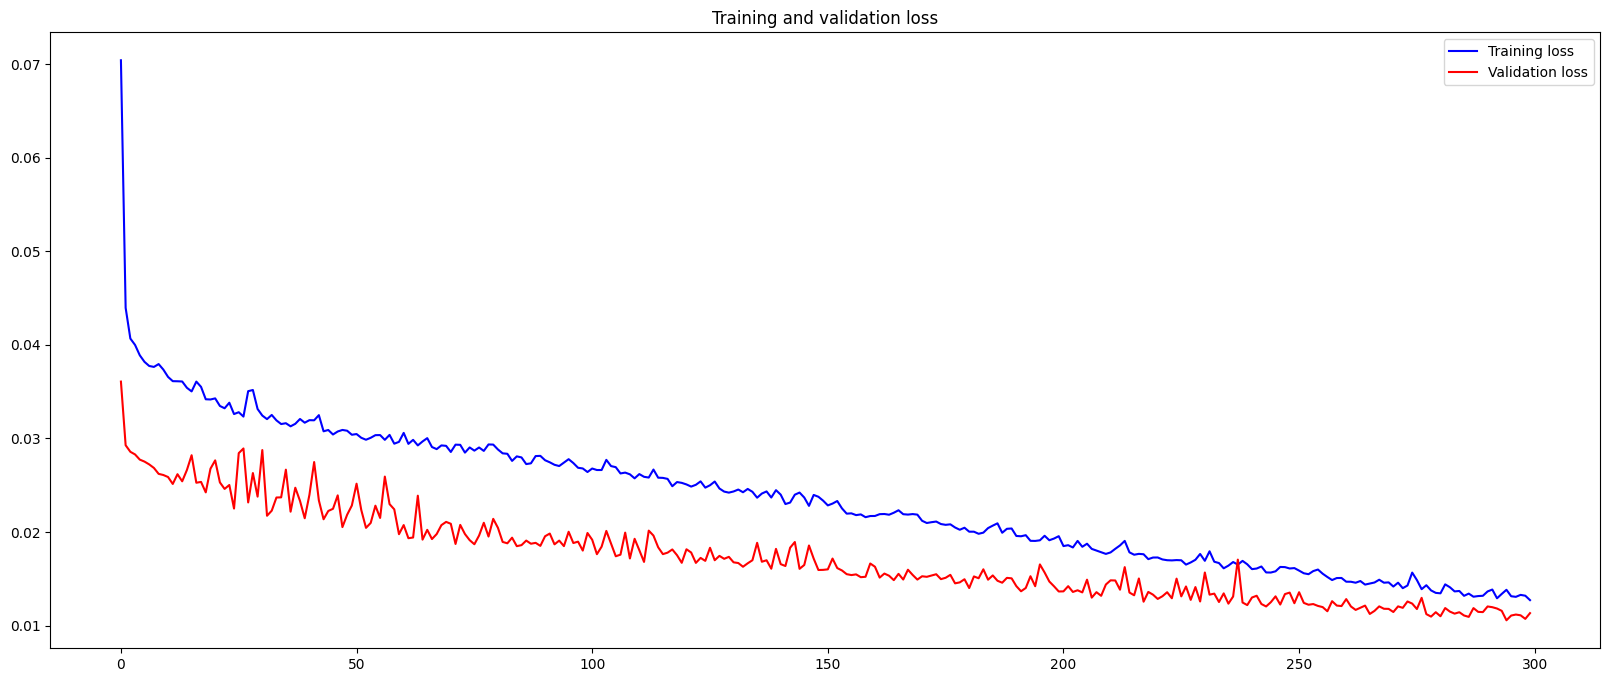

In [21]:
plot_loss(history_conv_lstm)

In [22]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

34/34 [==============================] - 3s 36ms/step


{'mae': 0.008615133, 'mse': 0.00017426479, 'r2': 0.8442761301994324}

#### Plot predictions

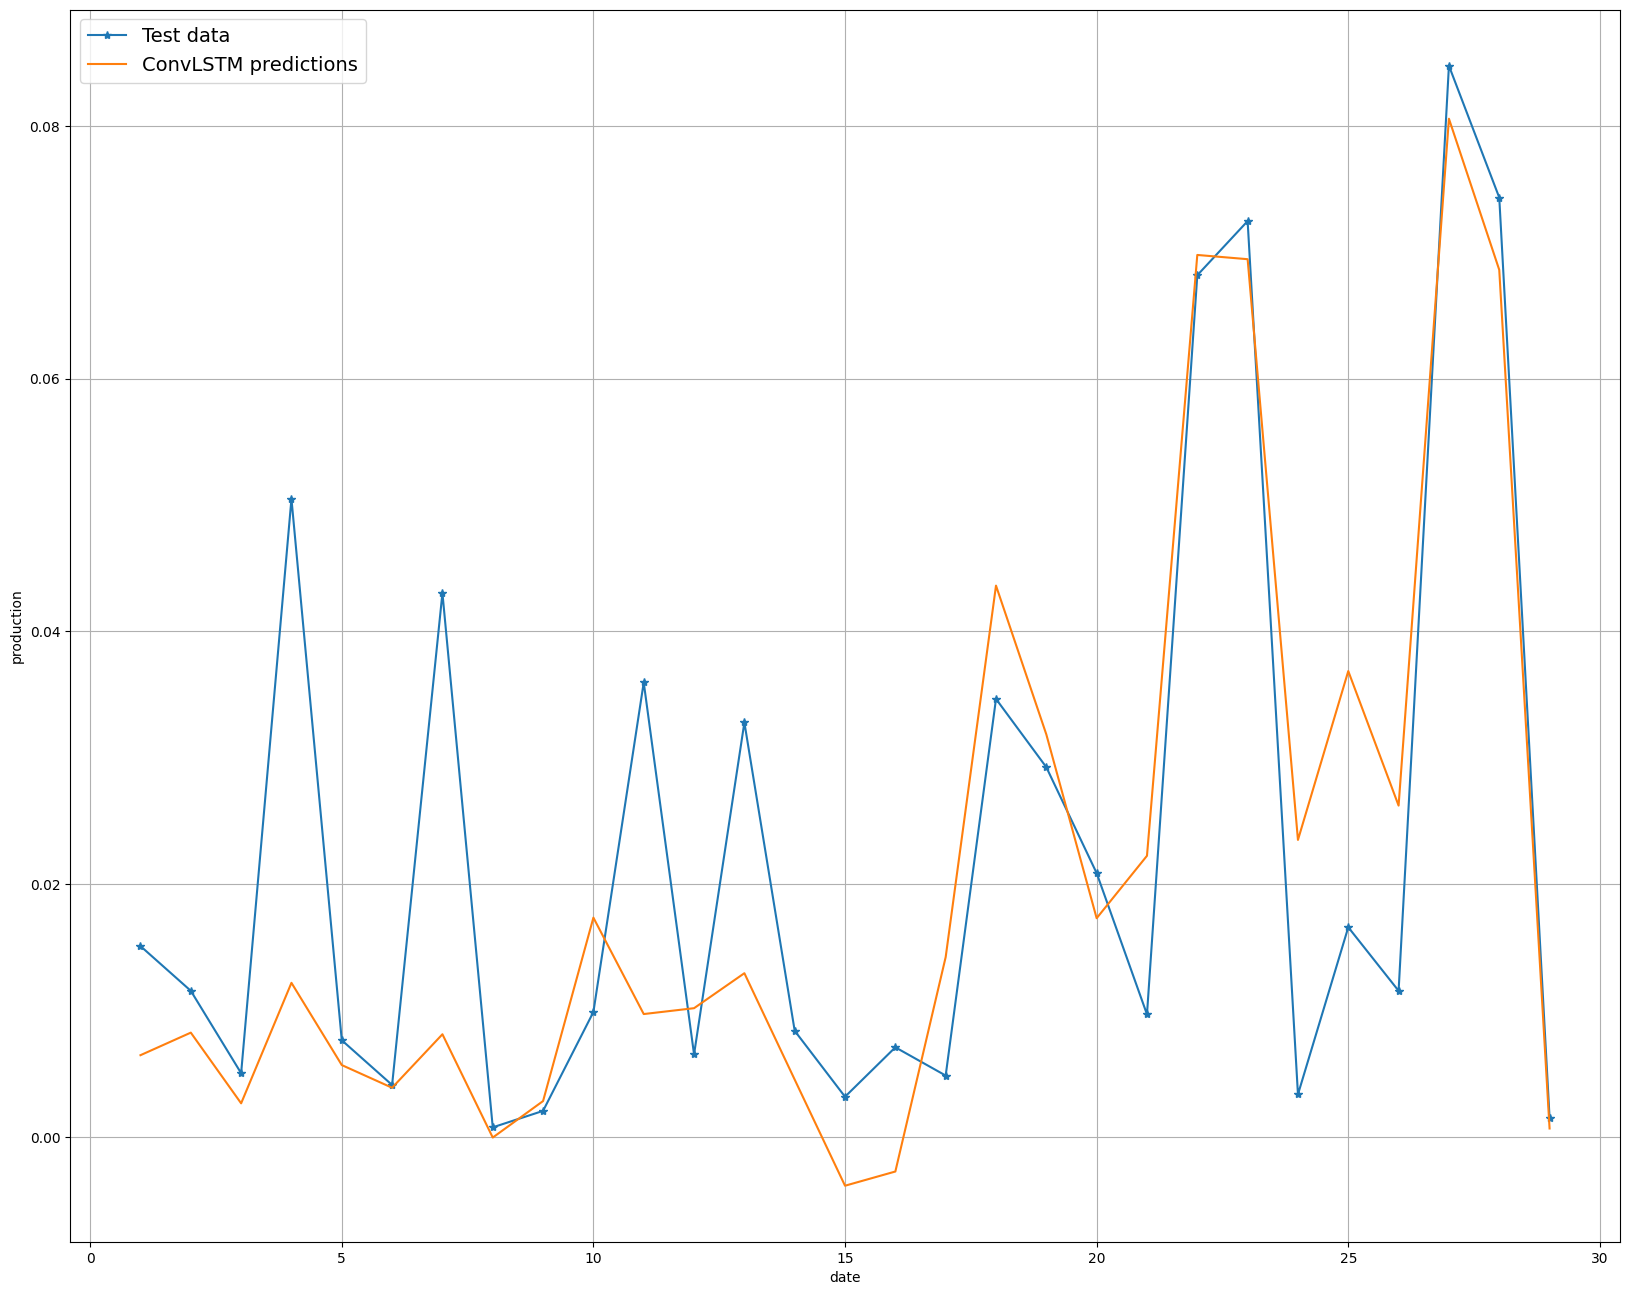

In [23]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)

In [24]:
import time
from deap import base, creator, tools
import random

# ========= Fonction modèle =========
def create_model(filters, kernel_size, activation, dense_units, learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.ConvLSTM1D(filters=int(filters), kernel_size=(int(kernel_size),), activation=activation,
                                   return_sequences=True, input_shape=x_train_conv_lstm.shape[1:]),
        tf.keras.layers.ConvLSTM1D(filters=int(filters), kernel_size=(int(kernel_size),), activation=activation,
                                   return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=int(dense_units), activation='relu'),
        tf.keras.layers.Dense(1, activation="linear")
    ])
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

# ========= Fonction évaluation =========
def evaluate(individual):
    filters, kernel_size, activation, dense_units, learning_rate = individual
    model = create_model(filters, kernel_size, activation, dense_units, learning_rate)
    
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=1,
        restore_best_weights=True
    )
    
    history = model.fit(
        x_train_conv_lstm, y_train,
        epochs=2,
        batch_size=128,
        verbose=0,
        validation_data=(x_val_conv_lstm, y_val),
        callbacks=[early_stop]
    )
    
    mae = history.history['val_loss'][-1]
    return (mae,)

# ========= Mutation et croisement =========
def mut_mixed(ind, indpb=0.2):
    for i in range(len(ind)):
        if i == 1:
            continue
        if random.random() < indpb:
            if isinstance(ind[i], float):
                ind[i] += random.gauss(0, 0.001)
                ind[i] = max(0.0001, min(0.01, ind[i]))
            elif isinstance(ind[i], int):
                ind[i] += random.randint(-8, 8)
                ind[i] = max(1, min(256, ind[i]))
            elif isinstance(ind[i], str):
                ind[i] = 'relu' if ind[i] == 'tanh' else 'tanh'
    return ind,

def cx_mixed(ind1, ind2):
    for i in range(len(ind1)):
        if random.random() < 0.5:
            ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

# ========= Configuration DEAP =========
if not hasattr(creator, "FitnessMin"):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("filters", random.choice, [32, 64, 128])
toolbox.register("kernel_size", random.choice, [1])
toolbox.register("activation", random.choice, ['relu', 'tanh'])
toolbox.register("dense_units", random.choice, [32, 64, 128])
toolbox.register("learning_rate", random.uniform, 0.0001, 0.008)

toolbox.register("individual", tools.initCycle, creator.Individual,
    (toolbox.filters, toolbox.kernel_size, toolbox.activation, toolbox.dense_units, toolbox.learning_rate), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cx_mixed)
toolbox.register("mutate", mut_mixed, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# ========= Exécution GA avec meilleur global =========
start_ga_time = time.time()

n_generations = 4
population_size = 10

population = toolbox.population(n=population_size)
best_overall = None

for gen in range(n_generations):
    print(f"\n Génération {gen+1}")
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Suivi du meilleur global
    gen_best = tools.selBest(population, 1)[0]
    if best_overall is None or gen_best.fitness.values[0] < best_overall.fitness.values[0]:
        best_overall = creator.Individual(gen_best)
        best_overall.fitness.values = gen_best.fitness.values

    print(" Population :")
    for i, ind in enumerate(population):
        print(f"  ➤ Individu {i+1}: {ind} ➤ MAE = {ind.fitness.values[0]:.4f}")

    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for c1, c2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(c1, c2)
            del c1.fitness.values, c2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalids = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalids))
    for ind, fit in zip(invalids, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring

end_ga_time = time.time()

# ========= Réentraînement final =========
print(f"\n Meilleurs hyperparamètres globaux trouvés : {best_overall}")
filters, kernel_size, activation, dense_units, learning_rate = best_overall
model = create_model(filters, kernel_size, activation, dense_units, learning_rate)

start_train_opt = time.time()
model.fit(x_train_conv_lstm, y_train, epochs=300, batch_size=512, verbose=1,
          validation_data=(x_val_conv_lstm, y_val))
training_time_opt = time.time() - start_train_opt

# ========= Évaluation finale =========
y_pred = model.predict(x_test_conv_lstm)
r2 = r2_score(y_test, y_pred)
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mae_metric.update_state(y_test, y_pred)
mae = mae_metric.result().numpy()


# ========= Affichage final =========
print("\n Résumé des performances :")
print(f"  ➤ R² de base              : {model_results['r2']:.4f}")
print(f"  ➤ MAE de base             : {model_results['mae']:.4f}")
print(f"  ➤ Temps entraînement base : {training_duration_conv_lstm:.2f} s")
print(f"  ➤ R² optimisé             : {r2:.4f}")
print(f"  ➤ MAE optimisé            : {mae:.4f}")
print(f"  ➤ Temps entraînement opti : {training_time_opt:.2f} s")
print(f"  ➤ Temps GA total          : {end_ga_time - start_ga_time:.2f} s")
print(f"  ➤ Hyperparamètres choisis : {best_overall}")



 Génération 1
 Population :
  ➤ Individu 1: [128, 1, 'relu', 128, 0.0005157771825206476] ➤ MAE = 0.0275
  ➤ Individu 2: [128, 1, 'tanh', 64, 0.005313887369782282] ➤ MAE = 0.0271
  ➤ Individu 3: [32, 1, 'tanh', 32, 0.0015474189477487459] ➤ MAE = 0.0270
  ➤ Individu 4: [64, 1, 'relu', 128, 0.005298990478100931] ➤ MAE = 0.0276
  ➤ Individu 5: [64, 1, 'tanh', 32, 0.0023261665187169207] ➤ MAE = 0.0268
  ➤ Individu 6: [128, 1, 'relu', 64, 0.005123200907660045] ➤ MAE = 0.0269
  ➤ Individu 7: [128, 1, 'tanh', 128, 0.005961097935283137] ➤ MAE = 0.0275
  ➤ Individu 8: [64, 1, 'tanh', 128, 0.004315696513243673] ➤ MAE = 0.0269
  ➤ Individu 9: [64, 1, 'tanh', 32, 0.00392859648929962] ➤ MAE = 0.0281
  ➤ Individu 10: [32, 1, 'relu', 32, 0.004695869009413298] ➤ MAE = 0.0282

 Génération 2
 Population :
  ➤ Individu 1: [64, 1, 'relu', 128, 0.0023261665187169207] ➤ MAE = 0.0274
  ➤ Individu 2: [128, 1, 'tanh', 32, 0.0005157771825206476] ➤ MAE = 0.0273
  ➤ Individu 3: [128, 1, 'tanh', 128, 0.00431569651